# Reporte 8: Instrumental Variables (IV)

## Código
Estudiantes: Roxana Rodriguez Pilco (20200373), Greysi Arrelucea Castañeda (20200279) y Angela Rodriguez Fernández (20200748)

In [1]:
from causalgraphicalmodels import CausalGraphicalModel
import matplotlib.pyplot as plt
import os
import numpy as np 
import pandas as pd 
import statsmodels.api as sm 
import statsmodels.formula.api as smf 
from itertools import combinations 
import plotnine as p
import statsmodels.api as sm
import statsmodels.formula.api as smf
import linearmodels.iv.model as lm
from linearmodels.iv import IV2SLS
from statsmodels.iolib.summary2 import summary_col
import seaborn as sns

### 1. Variables instrumentales
Para que las variables instrumentales trabajen, se debe satisfacer principalmente 2 supuestos: el suspuesto de relevancia y el de validez del instrumento.

#### 1.1) Explique en qué consiste el supuesto de "Relevance"

La relevancia nos permite ver los supuesto de identificación y uso de variables instrumentales de manera más certera, para así saber que 'Z' (la variable instrumental) se relaciona realmente con 'X' (la variable de tratamiento). De modo que, se busca que la variable instrumental Z si funcione y se evite la endogeneidad(D), es decir, que la variable independiente se correlacione con el de error en una regresión. Es así como la relevancia evalúa la relación entre parte de la variable independiente'X' y la variable instrumental 'Z' y ve cuán fuerte es, es decir, si la variable Z logra explicar en parte o totalmente la variable independiente X. Cuanto más fuerte sea esta relación, más confianza habrá en  el supuesto de relevancia y menos saltará la estimación de una muestra a otra.

#### 1.2) Explique en qué consiste el supuesto de "Validity"

El supuesto de validez implica que cualquier ruta entre el instrumento Z y el resultado Y (variable dependiente) debe pasar con anterioridad por la variable independiente o el tratamiento X o en todo caso cerrarse para que la suposición sea válida. La validez es también llamada una restricción de exclusión porque supone que el instrumento Z puede ser excluido razonablemente del modelo de Y luego de que la ruta  Z → X sea incluida. 
Por ejemplo, para que el supuesto de validez se cumpla para la variable instrumental Z, se necesita cerrar tanto la ruta Z ← B →Y como la ruta Z → A → Y. Entonces, si se puede controlar las variables A y B , entonces el supuesto se cumple.

Por tanto, la validez, efectivamente supone que el instrumento Z es una variable que no tiene puertas traseras abiertas.

### 2. Ploteo de Histogramas

#### 2.1) Grafique dos histogramas para la variable años de educación "educ" para cuando nearc4 == 1, y cuando nearc4 == 0. Compare y describa los patrones que encuentra.

In [2]:
# se carga la data
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

def read_data(file): 
    return pd.read_stata("https://raw.github.com/scunning1975/mixtape/master/" + file)

card = read_data("card.dta")
card.head()

,id,nearc2,nearc4,educ,age,fatheduc,motheduc,weight,momdad14,sinmom14,...,KWW,IQ,married,libcrd14,exper,lwage,expersq,u_lwage,lwage_hat,u_educ
0,2.0,0.0,0.0,7.0,29.0,NaN,NaN,158413.0,1.0,0.0,...,15.0,NaN,1.0,0.0,16.0,6.306275,256.0,0.198047,6.108228,-3.067539
1,3.0,0.0,0.0,12.0,27.0,8.0,8.0,380166.0,1.0,0.0,...,35.0,93.0,1.0,1.0,9.0,6.175867,81.0,-0.211160,6.387027,-1.727562
2,4.0,0.0,0.0,12.0,34.0,14.0,12.0,367470.0,1.0,0.0,...,42.0,103.0,1.0,1.0,16.0,6.580639,256.0,0.204719,6.375920,1.012975
3,5.0,1.0,1.0,11.0,27.0,11.0,12.0,380166.0,1.0,0.0,...,25.0,88.0,1.0,1.0,10.0,5.521461,100.0,-0.967905,6.489366,-2.253536
4,6.0,1.0,1.0,12.0,34.0,8.0,7.0,367470.0,1.0,0.0,...,34.0,108.0,1.0,0.0,16.0,6.591674,256.0,0.125173,6.466501,1.090437


- Histogramas separados de la variable educ (años de eduación) a partir de la variable nearc4(si no existe (0) o existe (1) una universidad de 4 años en el condado)

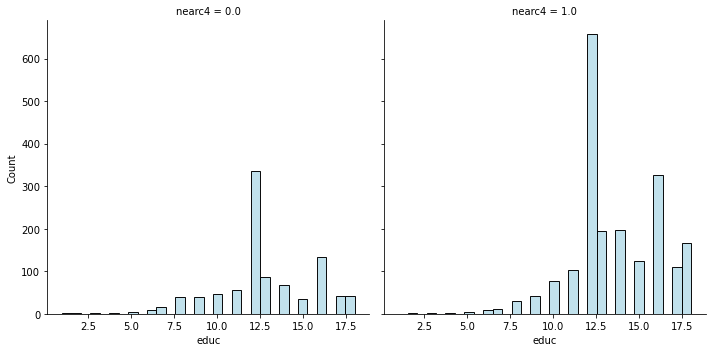

In [3]:
sns.displot(card, x="educ", col="nearc4", color='lightblue') 

- Histogramas traslapados

Text(8.557222222222222, 0.5, 'Frecuencia')

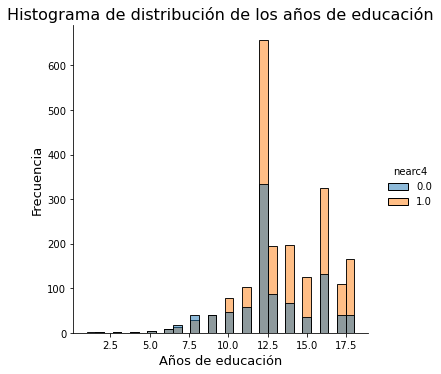

In [4]:
sns.displot(card, x="educ", hue="nearc4")  
plt.title("Histograma de distribución de los años de educación", fontsize=16)
plt.xlabel("Años de educación", fontsize=13)
plt.ylabel("Frecuencia", fontsize=13)

- Interpretación

A partir de los histogramas, por un lado se puede analizar que la la proximidad de una institución de educación superior se correlaciona con el aumento de años de educación. Incluso, se podría decir que la presencia de universidades de 4 años en el condado de la población que conforma la muestra aumenta la posibilidad de asistir a la universidad y obtener estudios superiores. Por otro lado, la ausencia de una institución de educación superior de 4 años cercana al condado no muestra una relación fuerte a comparación con la situación donde estas si están cercanas al condado. 

Cabe destacar que en EE.UU, se empieza la educación en kindergarden a los 4 o 5 años y a los 18 años los estudiantes se preparan para postular a la universidad, por tanto son aproximadamente 12.5 o 13 años de educación inicial, primaria y secundaria hasta antes de empezar educación superior. Así pues, se evidencia que cuando hay instituciones de educación superior de 4 años cerca del condado de la muestra, estos tienen mayores probabilidades de alcanzar un mayor nivel de educación y continuar estudios superiores. Por tanto, mediante la tendencia y distribución podemos decir que este efecto de los centros de educacion superior de 4 años cercanos al condado en las probabilidades de mayor nivel de educación se muestra a partir de los 10 años de educación en adelante. Entre los 7.5 años de educación y los 10 años, se evidencia una neutralidad, pues tanto habiendo universidades de 4 años cercanas como no, el nivel de educación de la muestra es el mismo. Finalmente, los valores atípicos son pocos y se relacionan con pocos años de educación y la no proximidad de universidades con programas de 4 años a los hogares de la muestra.

#### 2.2) Grafique dos histogramas para la variable años del logaritmos de los ingresos "lwage" para cuando nearc4 == 1, y cuando nearc4 == 0. Compare y describa los patrones que encuentra.

- Histogramas separados de la variable lwage (logaritmo de los ingresos) a partir de la variable nearc4(si no existe (0) o existe (1) una universidad de 4 años en el condado) 

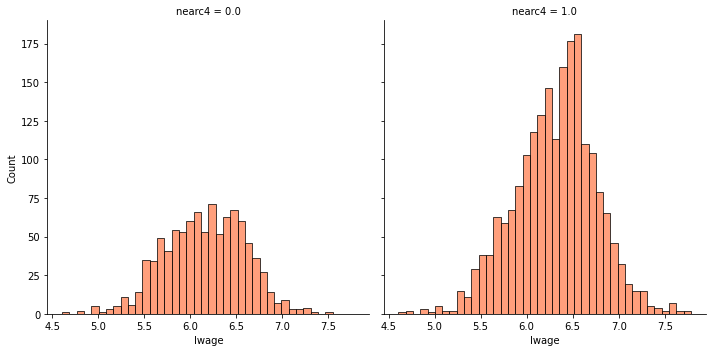

In [5]:
sns.displot(card, x="lwage", col="nearc4", color='coral') 

- Histogramas traslapados

Text(8.557222222222222, 0.5, 'Frecuencia')

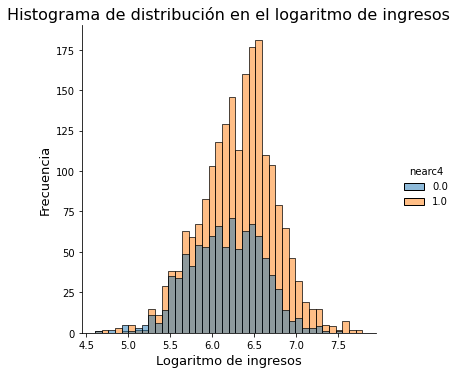

In [6]:
sns.displot(card, x="lwage", hue="nearc4") 
plt.title("Histograma de distribución en el logaritmo de ingresos", fontsize=16)
plt.xlabel("Logaritmo de ingresos", fontsize=13)
plt.ylabel("Frecuencia", fontsize=13)

- Interpretación:

A partir de los histogramas tanto separados como traslapados, se puede observar que la cercanía a un centro de estudios superiores con programas de 4 años de estudio tiene algun efecto o relación con el logaritmo de ingresos de la muestra. Se evidencia que hay una distribución normal tanto en los casos cuando hay universidades con programas de 4 años cercanas al condado como cuando no las hay, lo que implica que existe una distribución simétrica de datos. 

También se muestra que la existencia de centros de educación superior con programas de 4 años en las cercanías del condado tiene un impacto visible, significativo y directo en los logaritmos de ingresos de la muestra. Estos se ven mayormente a partir de los 6 y 7 años de educación donde se muestra como aumenta los logaritmos de ingresos en el caso de universidades con programas de 4 años en las proximidades del hogar. En suma, la presencia de universidades con programas de 4 años en las proximidades del condado tiene un efecto significativo y directo sobre el logaritmo de ingresos.

### 3. Regresiones

Ahora se realizan regresiones teniendo como instrumento Z a nearc2 (presencia (1) o no (0) de centros de estudios superiores con programas de 2 años de estudios).

#### 3.1) Corran una regresion lineal del tipo "lwage ~ educ + exper + black + south + married + smsa", y expliquen los resultados que encuentran.

In [7]:
#OLS
ols_reg = sm.OLS.from_formula("lwage ~ educ + exper + black + south + married + smsa", 
              data = card).fit()

ols_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  lwage   R-squared:                       0.305
Model:                            OLS   Adj. R-squared:                  0.304
Method:                 Least Squares   F-statistic:                     219.2
Date:                Sun, 13 Nov 2022   Prob (F-statistic):          1.97e-232
Time:                        17:25:41   Log-Likelihood:                -1273.9
No. Observations:                3003   AIC:                             2562.
Df Residuals:                    2996   BIC:                             2604.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.0633      0.064     79.437      0.000       4.938       5.188
educ           0.0712      0.003     20.438      0.000       0.064       0.078
exper          0.0342      0.002     15.422      0.000       0.030       0.038
black         -0.1660      0.018     -9.426      0.000      -0.201      -0.131
south         -0.1316      0.015     -8.788      0.000      -0.161      -0.102
married       -0.0359      0.003    -10.547      0.000      -0.043      -0.029
smsa           0.1758      0.015     11.372      0.000       0.145       0.206
==============================================================================
Omnibus:                       53.196   Durbin-Watson:                   1.858
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               69.430
Skew:                          -0.231   Prob(JB):                     8.38e-16
Kurtosis:                       3.584   Cond. No.                         154.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- Explicación de resultados:

En este modelo de regresión se busca encontrar si existe una correlación entre el logaritmo de ingresos (lwage) y las variables independientes (años de educación[educ], experiencia [exper], si es de raza negra o no[black], si es del sur o no[south], si es casado o no[married] y la variable smsa). No se considera a las variables nearc4 ni nearc2. Como todas las variables cuentan con un p-value menor a 0.05, todas son significativas para el modelo. El R2(r-square) indica que el modelo explica en 30% la variabilidad de la variable dependiente(logaritmos de ingresos), por ende, el modelo no es tan fuerte, ya que no sobrepasa el 50%. El coeficiente de la variable años de educación (educ) nos indica que por cada aumento de los años de educación, los ingresos de los encuestados aumentan en 7.1%.

- Al haber valores invalidos en la variable married,esto se rellenan con ceros para que no afecte el resultado del modelo de regresión.

In [8]:
card['married'] = card['married'].fillna(0)

#### 3.2) Corran una regresion de tipo IV(usando el paquete IV2SLS) donde van a instrumentalizar la variable educ con nearc2 .
La regresión debería tener una forma de este tipo "lwage ~ 1 + exper + black + south + married + smsa + [educ ~ nearc2]".

In [9]:
#IV2SLS
iv_reg = IV2SLS.from_formula("lwage ~  1 + exper + black + south + married + smsa + [educ ~ nearc2]", card).fit()
iv_reg.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:                  lwage   R-squared:                     -1.3114
Estimator:                    IV-2SLS   Adj. R-squared:                -1.3160
No. Observations:                3010   F-statistic:                    289.62
Date:                Sun, Nov 13 2022   P-value (F-stat)                0.0000
Time:                        17:25:41   Distribution:                  chi2(6)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      0.1276     3.1412     0.0406     0.9676     -6.0290      6.2843
black          0.1134     0.1816     0.6244     0.5324     -0.2425      0.4692
exper          0.1515     0.0747     2.0274     0.0426      0.0050      0.2980
married       -0.0151     0.0147    -1.0258     0.3050     -0.0438      0.0137
smsa           0.0201     0.1030     0.1949     0.8455     -0.1819      0.2220
south         -0.0319     0.0692    -0.4603     0.6453     -0.1675      0.1038
educ           0.3618     0.1849     1.9562     0.0504     -0.0007      0.7243
==============================================================================

Endogenous: educ
Instruments: nearc2
Robust Covariance (Heteroskedastic)
Debiased: False
"""

- Explicación de resultados:

Al crear un nuevo modelo de regresión lineal donde se utilice como instrumento (Z) a la variable nearc2 (la presencia o no de centros de estudios superiores con programas de 2 años), se busca encontrar que esta tiene un efecto en la variable años de educación (educ=X) y mediante X esta tiene un efecto en el resultado (logaritmos de ingresos=Y). Se observa que no todas las variables son significativas a diferencia del modelo de regresión anterior, pues solo las variables experiencia y años de educación (esta presenta un p.value redondeado de 0.05, por lo que aun lo consideraremos) lo son. Además, por cada año adicional de educación, los ingresos de las personas que conforman la muestra aumentan aproximadamente en un 36%.  En este sentido, se puede decir que se encuentra un mayor aumento del logaritmo de ingresos al instrumentalizar el modelo de regresión en comparación con el modelo de regresión OSL. El modelo presenta un r ajustado negativo que señala la neutralidad ante la introducción de variables adicionales y el F-statistics tiene un exceso de 15, por tanto,se señala que el instrumento no es débil. 

##### Compare los resultados encontrados en la regresión de arriba. ¿Cambió el coeficiente relacionado a educ , por qué?

Al observar ambos modelos de regresión , tanto el instrumentalizado (de tipo IV) en base a la variable instrumental nearc2 como el que no presenta ninguna variable instrumental (OSL), se evidencia un cambio en el coeficiente de la variable años de educación (educ), lo que se presume que está relacionado con la introducción del instrumento nearc2 (presencia (==1) o no(==0) de un centro de educación superior con programas de 2 años de estudios cerca al condado) en el modelo 2 (regresión de tipo IV). Confirmándose así que la presencia de centros de estudios superiores con programas de 2 años cerca al lugar de residencia de la muestra cumple un rol importante en la continuación de estudios superiores, en los años de educación y finalmente en el logaritmo de ingresos.

# Lectura

“Los efectos persistentes de la mita minera en el Perú” es una investigación que busca evaluar si la mita minera tiene un efecto a largo plazo en el desarrollo económico actual de ciertas regiones en el Perú y Bolivia. Cabe destacar que la mita minera era un tipo de trabajo forzado que se estableció a lo largo del periodo colonial e implicaba que las comunidades indígenas se veían obligadas a enviar cierta parte de su población masculina y adulta a trabajar en las minas de Potosí y Huancavelica, las cuales contenían palta y mercurio. El estudio relata que a pesar de que este tipo de trabajo forzado fue abolido en 1812 y en la actualidad ya no es aplicado, la mita minera ha afectado el desarrollo económico actual de los distritos y regiones donde fue empleada anteriormente. Por consiguiente, la pregunta de investigación que guía este estudio es: ¿Cuáles son los efectos a largo plazo de la mita minera en el desarrollo económico actual de los distritos de Perú y Bolivia donde se aplicó este sistema de trabajo forzado? Ante esta pregunta, los investigadores identifican que la tenencia de la tierra, los bienes públicos y la participación en el mercado son tres canales mediante los cuales la mita tiene un efecto a largo plazo persistente en el desarrollo económico actual de dichos distritos.

El presente estudio emplea un enfoque de regresión discontinua (RD) para analizar los efectos a largo plazo de la mita minera en el desarrollo económico de ciertos distritos en Perú y Bolivia. Los investigadores aplicaron este enfoque porque la población que era enviada a trabajar en las minas presentaba variaciones de acuerdo a la región, en otras palabras, las comunidades ubicadas en las proximidades de las minas enviaban muchos hombres adultos y las que no se ubicaban en el límite de las minas no estaban obligadas a enviar parte de su población masculina y adulta. En este sentido, la regresión discontinua consiste en realizar la regresión en base al límite de la región sometida a la mita y la no sometida, lo que permite que en el espacio longitud-latitud se cree una discontinuidad multidimensional. Asimismo, la autora establece que la validez del diseño de regresión discontinua (DF) implica que todos los factores deben variar de manera moderada en el límite donde se realizaba la mita minera, motivo por el cual ella centra su estudio en la zona que corta la cordillera de los Andes (el sur peruano).

El uso del enfoque RD presenta fortalezas y debilidades. En primer lugar, una fortaleza de realizar la regresión en base al límite de la región sometida a la mita y la no sometida es que implica una innovación en comparación con los estudios tradicionales de regresión discontinua que utilizaban umbrales unidimensionales. Esto beneficia a la investigación, porque permite que la mita minera sea tratada como una función discontinua y determinada de las covariables latitud y longitud. En segundo lugar, otra fortaleza del enfoque es que permite la elaboración de gráficos de dispersión tridimensionales a partir de cada distrito evaluado, generando que los lectores tengan una experiencia más dinámica y una mejor comprensión de los hallazgos en las regiones geográficas afectadas por la mita minera.

En tercer lugar, una limitación del enfoque se presenta a partir de la naturaleza de los datos a disposición de la autora, pues para aplicar una regresión discontinua no paramétrica es necesario contar con una georreferenciación muy precisa, es decir, tener a disposición las coordenadas o la longitud y latitud de cada observación de la población muestral. No obstante, los micro grupos de datos del Perú con los que cuenta la autora no tienen este tipo de información, e incluso algunos de ellos presentan tamaños de muestra insuficientes como para utilizar este método no paramétrico. Cabe desatacar que la investigación aborda esta debilidad al plantear un enfoque de regresión discontinua semi-paramétrico mediante el cual la muestra se limitaría a distritos ubicados dentro de los cincuenta kilómetros del límite de la mita minera. Identificando así, los efectos causales en el desarrollo económico y los 3 canales de persistencia de estos. Así pues, se verificó que las grandes haciendas no se desarrollaron en zonas donde se aplicaba la mita minera, lo que afectó negativamente el desarrollo económico actual en dichas áreas, también se evidenció a partir de hallazgos econométricos que el sometimiento a la mita significó una disminución a largo plazo de los niveles de educación en estas zonas y, por último, otro efecto fue la persistencia de la agricultura de subsistencia y autoconsumo, en vez de una más desarrollada y comercial.

A pesar de cierta debilidad del enfoque, no se puede olvidar que la investigación contribuye efectivamente a nivel teórico y práctico. Por un lado, a nivel teórico, el estudio simboliza una innovación relevante en el campo de investigación, ya que, si bien muchos estudios anteriores establecían que la mita minera afectaba el desarrollo económico actual, ninguno de estos demarcó los canales de influencia por los que se producían estos efectos. Asimismo, otro aporte es que permite que se repiense cierta teoría tradicional sostenida por muchos estudiosos, la cual consiste en que la desigualdad histórica sobre el acceso a la tierra es la causa del limitado crecimiento económico en Latinoamérica y que específicamente, en Perú existe una relación positiva entre las grandes haciendas y el desarrollo económico actual. De modo que, el estudio presenta importantes evidencias macroeconómicas que demuestran que las grandes haciendas aseguraron los bienes públicos y aislaron a los campesinos de instituciones extractivas del Estado, lo que lo convierte en el punto de partida para no dejar en el olvido esta importante teoría del crecimiento económico a largo plazo en América Latina y mas bien complementarla con más canales de influencia.

Por otro lado, a nivel práctico, esta investigación permite mejorar el diseño de las políticas públicas focalizadas en las regiones donde se ha visto que las instituciones históricas como la mita han afectado su desarrollo económico. De manera que, haya mayor apoyo económico y proyectos de modernización de actividades económicas como la agricultura en dichas zonas, pues se ha evidenciado que, dado el limitado crecimiento económico en estos distritos, los pobladores se encuentran en una situación de desventaja en comparación con las zonas que no fueron sometidas a este sistema de trabajo forzado.

En conclusión, para avanzar en esta pregunta de investigación, la misma autora recomienda un paso específico. Este es realizar más modelos generales sobre la evolución de instituciones históricas en base a investigaciones empíricas que muestren como estas cambian a partir de fuerzas externas. Asimismo, un último paso a seguir sería profundizar en el efecto de la mita minera en el desarrollo económico de Bolivia, pues el presente estudio no se centró mucho en esta zona e igualmente también estudiar su efecto en otras zonas de América Latina donde este sistema de trabajo forzado fue aplicado. De manera que se pueda corroborar si los efectos también fueron a largo plazo en estas zonas y similares o contrastantes con respecto a los resultados encontrados para el caso peruano. Por ejemplo, Quezada (1996) establece que la aplicación de la mita durante la colonia originó el estancamiento de la economía boliviana durante el siglo XIX, pues ocasionó que la inserción de dicha economía al mercado mundial fuera difícil y en condiciones competitivas desventajosas con respecto a otros países. Asimismo, el autor presume que, dado que la mita tiene un efecto a largo plazo, este continuaría limitando a futuro el desarrollo agropecuario y económico del país. Por tal motivo, es de suma importancia que se continúe investigando los efectos de esta institución histórica en la región latinoamericana para los años siguientes al siglo 19, tal como se estudió el caso peruano.

- BIBLIOGRAFÍA

Quezada,O. (1996). La mita como forma de organización y explotación del factor trabajo [Tesis doctoral,Universidad Mayor de San Andrés].Repositorio institucional de la Universidad Mayor de San Andrés.http://repositorio.umsa.bo/xmlui/handle/123456789/25145